# Bitcoin Exchange Rates

## final project for DSCI 6007

Charles Franzen

### Project Overview

#### Data Source

The data come from a REST api that provides bitcoin exchange rates in a variety of currency, updated every minute.

#### Project Goals

1) Gather data: Pull data continously from an api.

2) Data persistence: Keep all the data I gather

3) Data structuring: Transform data into 3NF for more efficient querying

4) Batch processing: Perform batch operations using a distributed system

5) Stream processing: Do real-time analysis on data as it comes in

6) Front end: Have a webserver that provides easy access to the results of the analysis.

#### DAG

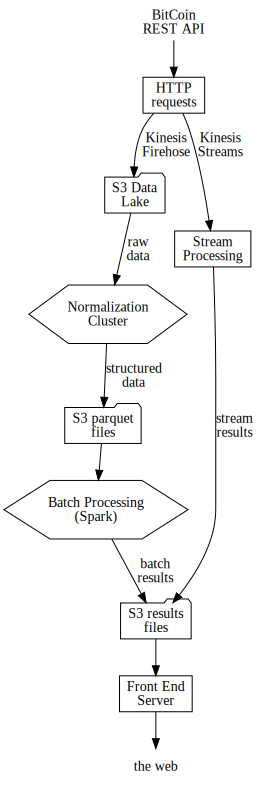

In [5]:
import graphviz as gv

g = gv.Source('''
digraph dataflow {
    I [label="BitCoin\nREST API", shape="plaintext"];
    R [label="HTTP\nrequests", shape="box"];
    DL [label="S3 Data\nLake", shape="folder"];
    S [label="Stream\nProcessing", shape="box"];
    CL [label="Normalization\nCluster", shape="hexagon"];
    S2 [label="S3 parquet\nfiles", shape="folder"];
    CL2 [label="Batch Processing\n(Spark)", shape="hexagon"];
    S3 [label="S3 results\nfiles", shape="folder"];
    FE [label="Front End\nServer", shape="box"];
    W [label="the web", shape="plaintext"];
    
    I -> R;
    R -> DL [label="Kinesis\nFirehose"];
    R -> S [label="Kinesis\nStreams"];
    DL -> CL [label="raw\ndata"];
    CL -> S2 [label="structured\ndata"];
    S2 -> CL2;
    CL2 -> S3 [label="batch\nresults"];
    S -> S3 [label="stream\nresults"];
    S3 -> FE;
    FE -> W;
    

}''')

g.save('dag.gv')
g

#### Project Details

##### Ingestion

I used the requests library to make HTTP requests to the Bitcoin Price Index. I used an EC2 instance and routed records into a Kinesis Firehose and a Kinesis Stream.

##### Storage

The Firehose goes to an S3 bucket, where the raw data are stored

##### Normalization

An EMR instance normalizes the data every day, using Spark. Structured data are output as parquet files and stored on S3. If I had time, I would have liked to explore time-series optimized databases, like Riak TS.

##### Batch Processing

For batch processing, I computed mins, maxs, and means for different time frames. I also computed moving averages over windows of time.

Originally I wanted to use batch processing to perfrom hyperparameter selection for my prediction model. This would have involved fitting a model to every 60-minute window in the dataset, for each set of parameters. Predictions would be compared with the true values, and RMSE used to evaluate relative model performance.

I was able to use Spark's windowing functionality to compute rolling means and standard deviations, but as of now Pyspark does not support user defined aggregation functions. I wrote one anyways and tested it in Pandas, though I wasn't able to spend enough time on it to find a really good model. Once this feature is added to Spark, I'll be ready to take advantage.

Results of batch processes were stored as pickled Pandas DataFrames.

##### Stream Processing

Since I only wanted to do stream processing on the latest hour of data, I just wrote a Stream consumer based on Pandas. It keeps a cache of the last 60 mins of data, fits a Gaussian Process Regressor, and makes 1, 5, and 10 minute projections.

The results are stored on S3 as pickled Pandas DataFrames.

##### Front End

I used Spyre to create a three-page front end. One page shows min, max, and averages rates over hours and days. Another shows the last day and week of full data, along with a rolling average. The final page shows the projections and the latest data from the stream processor.

#### Data System Considerations

##### Robustness and tolerance

S3 is very robust. If the stream goes down, short-term functionality will be lost on the front-end, but the data itself will be safe in S3. One point of concern is that the REST API will only be called on a single EC2 machine. An improvement would be to have a redundant http requester and S3 data lake, so that if a requester goes down there will be a backup.

##### Low latency reads and updates.

The Lambda architecture allows the low latency of stream processing to be supported by the robustness and fault-tolerance of S3 and distributed databases. Latency on batch processing will be high, but it's only used for long-term applications.

##### Scalability

Most of these technologies are fully scalable.

As for horizontal scaling: EC2, S3, and Spark are all highly scalable, horizontally. Spyre is only dealing with relatively small 'views' of the data, so it will scale fine as the data grows. However, if the number of data sources and desired views increases too much, a more heavy-duty front-end will be necessary.

The Kinesis consumer is not very scalable. If the volume of data grows dramatically, something like Flink or Spark Streaming will need to be implemented.

Fitting Gaussian Processes on more of the data might be a bit of a problem. As the data get bigger in terms of the number of points in the time-series, this technique scales fairly well: predictions can be made by keeping a small number of training points with an exponentially increasing distance between them further back in history. An issue is increasing the number of features. Gaussian Random Fields are extremely powerful, but also very computationally intensive. Scikit-learns implementations are pretty fast.

##### Generalization

This architecture will be extremely general. There are many, *many* REST APIs, and many time series that would benefit from short-term stream processing and long-term batch processing. Galaxies of financial data come in this form.

##### Extensibility

This project is easily extensible. All of the systems in place support the addition of new data sources, features, and models.

##### Ad hoc Queries

Ad hoc queries are a bit iffy. Since the structured data are stored as parquet files, the whole database has to be loaded into Spark to do a query. Getting the data into a real database, NoSQL or RDBMS, should improve query performance.

##### Minimal maintenance

This system will have to be monitored, but there's not too much that will have to be maintained. There is the single point of failure in the HTTP requester, but the data stream is not of variable volume, so the Kinesis stream and everything downstream of that should be ok once the system is up and running. Cronjobs will take care of schedule data structuring and batch processing. The front end will update on refresh. 

The system is complex, especially considering how little data there will actually be in it, but it's built to scale and handle Big Data if and when it comes, so some complexity is necessary to handle those requirements.

##### Debuggability

The data will always be stored in raw form in S3, so bugs can be ferreted out, data restructured, and models recomputed if the worst happens and later layers get corrupted. I'll be doing my best to annotate code and provide guidance to those examining my system.